In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import itertools
import numpy as np
import matplotlib.pyplot as plt

# Python examples

This is a short description on how to use the DLR representation and the algorithms using this representation implemented in the python module `pydlr`.

If you find this useful in your work please cite the companion paper to the `pydlr` module, see the [citation information](background.rst).

## Dimer example

A simple example that can be solved trivially as a two state system is the hybridized fermionic dimer system.

The second quantized Hamiltonian $H$ is given by

$$
H = e_1 c_1^\dagger c_1 + e_2 c_2^\dagger c_2 + V ( c_1^\dagger c_2 + c_2^\dagger c_1) \, ,
$$

where $e_1$ and $e_2$ are the energies of the two levels and $V$ is their hybridization. In matrix form the Hamiltonian takes the form

$$
H = 
\left[\begin{array}{c} c_1^\dagger c_2^\dagger \end{array}\right] 
\cdot
\left[\begin{array}{cc} e_1 & V \\ V & e_2 \end{array}\right] 
\cdot
\left[\begin{array}{c} c_1 \\ c_2 \end{array}\right] 
\, .
$$

The single particle Green's function $G_{ab}(\tau)$ is a $2 \times 2$ matrix in imaginary time $\tau \in [0, \beta]$

$$
G_{ab}(\tau) \equiv - \langle c_a(\tau) c_b^\dagger(0) \rangle
$$

and can be computed with `pydlr` as:

In [2]:
from pydlr import dlr

beta = 800.
e_1, e_2, V = 0.2, -0.5, 1.

h = np.array([
    [e_1, V],
    [V, e_2],])

d = dlr(lamb=2.*beta)

G_lab = d.free_greens_function_tau(h, beta)
tau_l = d.get_tau(beta)

In imaginary time the Green's function $G(\tau)$ is here represented using a carefully selected set of imaginary time nodes $\tau_l$.

Equivalently there is a set of carefully selected Matsubara frequency points $i\omega_w$ on which the Green's function can be represented.

The transform between these two spaces is done through the DLR coefficient representation at real-frequencies $\omega_x$. 

$$
\text{Imaginary time } G(\tau_l) \leftrightarrow \text{DLR coefficients } G_x \leftrightarrow \text{Matsubara frequency } G(i\omega_w)
$$



In [3]:
# Transform from imaginary time tau to DLR coefficients

G_xab = d.dlr_from_tau(G_lab)

# Transform DLR to imaginary time tau

G_lab_ref = d.tau_from_dlr(G_xab)
np.testing.assert_array_almost_equal(G_lab, G_lab_ref)

# Trasform from DLR to Matsubara frequencies

G_wab = d.matsubara_from_dlr(G_xab, beta)
w = d.get_matsubara_frequencies(beta)

Since the DLR coefficient representation gives the imaginary time representation as

$$
G(\tau) = \sum_{x} K_\beta (\tau, \omega_x) G_x
$$

where $K_\beta$ is the analytical continuation kernel at inverse temperature $\beta$. 

Thus the DLR coefficients can be used to evaluate $G(\tau)$ on any grid in imaginary time $\tau \in [0, \beta]$.

In [4]:
# Evaluate on arbitrary tau grid

tau_i = np.linspace(0, beta, num=1000)
G_iab = d.eval_dlr_tau(G_xab, tau_i, beta)

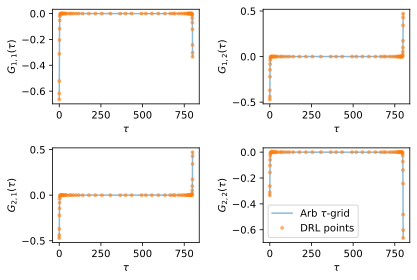

In [5]:
# Imaginary-time plot

subp = [2, 2, 1]

for a, b in itertools.product(range(2), repeat=2):
    plt.subplot(*subp); subp[-1] += 1
    plt.plot(tau_i, G_iab[:, a, b], '-', label=r'Arb $\tau$-grid', alpha=0.5)
    plt.plot(tau_l, G_lab[:, a, b], '.', label='DRL points', alpha=0.5)
    plt.ylabel(r'$G_{' + f'{a+1},{b+1}' + r'}(\tau)$')
    plt.xlabel(r'$\tau$')
    
plt.legend(loc='best');
plt.tight_layout()
plt.show()

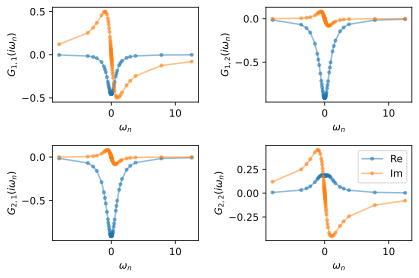

In [6]:
# Matsubara frequency plot

subp = [2, 2, 1]

for a, b in itertools.product(range(2), repeat=2):
    plt.subplot(*subp); subp[-1] += 1
    plt.plot(w.imag, G_wab[:, a, b].real, '.-', label='Re', alpha=0.5)
    plt.plot(w.imag, G_wab[:, a, b].imag, '.-', label='Im', alpha=0.5)
    plt.ylabel(r'$G_{' + f'{a+1},{b+1}' + r'}(i\omega_n)$')
    plt.xlabel(r'$\omega_n$')
    
plt.legend(loc='best');
plt.tight_layout()
plt.show()

## Dyson equation

The dimer example can also be used as a simple application of the Dyson equation. 

For example the 1,1 component of the Green's function $$G_{1,1}(\tau) = G(\tau)$$ can also be obtained from a system with single particle Hamiltonian $$h_1 = [e_1]$$ and a retarded self-energy $$\Sigma(\tau) = V^2 \cdot g_{e_2}(\tau)$$ where $g_{e_2}$ is the free Green's function for a single energy level $h_2 = [e_2]$.

In [7]:
h1 = np.array([[e_1]])

sigma_l = V**2 * d.free_greens_function_tau(np.array([[e_2]]), beta)

### Matsubara Dyson Equation

The Dyson equation for the single-particle Green's function $G$ is given by

$$
G(i\omega_n) = \left[ i\omega_n - h - \Sigma(i\omega_n) \right]^{-1}
$$

where $\omega_n$ are the Matsubara frequencies, $h$ is the single particle Hamiltonian and $\Sigma$ is the self-energy.

In [8]:
sigma_x = d.dlr_from_tau(sigma_l)
sigma_w = d.matsubara_from_dlr(sigma_x, beta)

G_w = d.dyson_matsubara(h1, sigma_w, beta)
G_l_matsubara = d.tau_from_dlr(d.dlr_from_matsubara(G_w, beta))

np.testing.assert_array_almost_equal(G_l_matsubara, G_lab[:, 0:1, 0:1])

### Imaginary time Dyson equation

An equivalent formulation in imaginary time is given by the integro-differential form

$$
(-\partial_\tau - h - \Sigma \, \ast ) G(\tau) = 0
$$

with the boundary condition $G(0) - \xi G(\beta) = -1$ and the imaginary time convolution

$$
\Sigma \ast G \equiv \int_{0}^\beta d\bar{\tau} \,
\Sigma(\tau - \bar{\tau}) G(\bar{\tau})
$$

In [9]:
G_x = d.dyson_dlr_integrodiff(h1, sigma_x, beta)
G_l_integrodiff = d.tau_from_dlr(G_x)

np.testing.assert_array_almost_equal(G_l_integrodiff, G_lab[:, 0:1, 0:1])

This can further be rewritten using the free Green's function $g$ defined as

$$
(-\partial_\tau - h ) g(\tau) = 0
$$

multiplying the integro-differential form from the left gives the Dyson equation in the integral formulation

$$
(1 + g \ast \Sigma \, \ast) \, G = g 
$$

In [10]:
G_l_integro = d.tau_from_dlr(d.dyson_dlr(h1, sigma_x, beta))

np.testing.assert_array_almost_equal(G_l_integro, G_lab[:, 0:1, 0:1])

While it is possible to solve the Dyson equation in all these ways the numerically most accurate is the last integral formulation in DLR space, as can be seen when comparing the errors.

In [11]:
error = lambda G_l : np.max(np.abs(G_l - G_lab[:, 0:1, 0:1]))

print(f'Error {error(G_l_matsubara):2.2E} Matsubara')
print(f'Error {error(G_l_integrodiff):2.2E} integrodiff')
print(f'Error {error(G_l_integro):2.2E} integro')

Error 6.43E-11 Matsubara
Error 1.41E-09 integrodiff
Error 3.75E-13 integro


## Non-linear problems

While the dimer system can be used to test the Dyson equation, it is more common to use it in problems where the self-energy $\Sigma$ is a functional of the Green's function itself

$$
\Sigma = \Sigma[G]
$$

Combined with the Dyson equation this gives the non-linear integral equation problem

$$
(1 + g \ast \Sigma[G] \, \ast ) \, G = g
$$

Here follows a few simple examples of non-linear problems.

### The semi infinite chain (or the Bethe graph)

The Green's function $G$ of the last site in the semi-infinite chain with onsite energy  $e$ and nearest-neightbour hopping $t$ can be determined recursively to obey the Dyson equation

$$
\left( -\partial_\tau - h - \frac{t^2}{4} G \, \ast \right) \, G = 0
$$

This equation can be solved analytically and be shown to correspond to a system with the semi-circular density of states

$$
\rho(\omega) = \frac{2}{\pi t^2} \sqrt{\left(\omega + t - h\right)\left(t + h - \omega\right)}
$$

whoose imaginary time Green's function is given by

$$
G(\tau) = -\int_{-\infty}^\infty K_\beta(\tau, \omega) \rho(\omega) \, d\omega
$$


norm = 0.9999664709734448


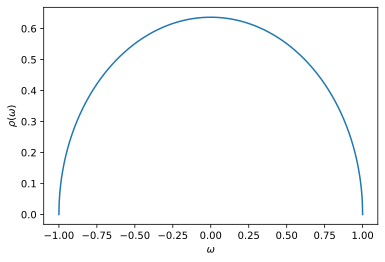

In [12]:
def dos(x, h, t):
    a = -t + h
    b = +t + h
    return 2./np.pi/t**2 * np.sqrt((x - a) * (b - x))


h = 0.0
t = 1.

x = np.linspace(-t + h, +t + h, num=1000)
rho = dos(x, h, t)

norm = np.trapz(rho, x=x)
print(f'norm = {norm}')

plt.figure()
plt.plot(x, rho)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
plt.show()

Since the density of states is known the imaginary time Green's function can be computed semi-analytically through the evaluation of the real-frequency integral. 

The integral can be computed to machine prescision using `scipu.integrate.quad` when accounting for the square root singularities using the `alg` weight function, see 

<https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html>

In [13]:
from pydlr import kernel
from scipy.integrate import quad

def eval_semi_circ_tau(tau, beta, h, t):
    I = lambda x : -2 / np.pi / t**2 * kernel(np.array([tau])/beta, beta*np.array([x]))[0,0]
    g, res = quad(I, -t+h, t+h, weight='alg', wvar=(0.5, 0.5))
    return g

eval_semi_circ_tau = np.vectorize(eval_semi_circ_tau)

beta = 100.
tau_l = d.get_tau(beta)

G_l = eval_semi_circ_tau(tau_l, beta, h, t)

Finally we solve the non-linear integrodifferential problem

$$
\left( -\partial_\tau - h - \frac{t^2}{4} G \, \ast \right) \, G = 0
$$

using forward iteration and compare to the semi-analytical result.

Converged in 521 iterations.
Error 5.18E-13 rel diff 9.75E-16


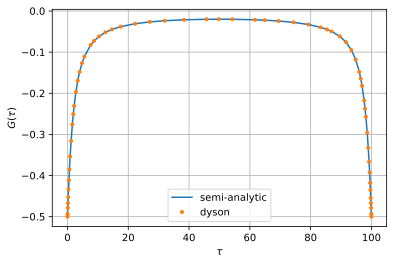

In [14]:
tol = 1e-15
max_iter = 1000

G_x = np.zeros((len(tau_l), 1, 1))
G_l_iter = np.zeros_like(G_x)

for iter in range(max_iter):
    
    G_x = d.dyson_dlr(np.array([[h]]), 0.25 * t**2 * G_x, beta)

    G_l_iter_new = d.tau_from_dlr(G_x)
    diff = np.max(np.abs(G_l_iter - G_l_iter_new))
    G_l_iter = G_l_iter_new

    if diff < tol:
        print(f'Converged in {iter+1} iterations.')
        break

print(f'Error {np.max(np.abs(G_l_iter[:, 0, 0] - G_l)):2.2E} rel diff {diff:2.2E}')

plt.figure()
plt.plot(tau_l, G_l, label='semi-analytic')
plt.plot(tau_l, np.squeeze(G_l_iter), '.', label='dyson')
plt.grid(True)
plt.legend(loc='best')
plt.ylabel(r'$G(\tau)$')
plt.xlabel(r'$\tau$')
plt.show()

### SYK-model example

The SYK model is given by the self-consistent second-order self energy

$$
\Sigma(\tau) = J^2 (G(\tau))^2 G(\beta - \tau) 
\, ,
$$

here the evaluation at $\beta - \tau$ can be obtained using the evaluation of DLR coefficients at arbitrary points in imaginary time.

In [15]:
def sigma_x_syk(g_x, J, d, beta):

    tau_l = d.get_tau(beta)
    tau_l_rev = beta - tau_l
    
    g_l = d.tau_from_dlr(g_x)
    g_l_rev = d.eval_dlr_tau(g_x, tau_l_rev, beta)
    
    sigma_l = J**2 * g_l**2 * g_l_rev
    sigma_x = d.dlr_from_tau(sigma_l)

    return sigma_x

The asymptotic conformal solution $G_c(\tau)$ is given by

$$
G_c(\tau) = - \frac{\pi^{1/4}}{\sqrt{2\beta}} \left( \sin \left( \frac{\pi \tau}{\beta} \right)\right)^{-1/2}
$$

In [16]:
def conformal_tau(tau, beta):
    return -np.pi**0.25 / np.sqrt(2 * beta) * 1./np.sqrt(np.sin(np.pi * tau/beta))

Finally we solve the non-linear integral equation

$$
(1 + g \ast \Sigma[G] \, \ast ) \, G = g
$$

using a root solver and the `df-sane` algorithm from `scipy.optimize.root`.

In [19]:
def solve_syk_root(d, mu, beta=1., J=1.0, g0_l=None, tol=1e-16, verbose=False):

    if verbose:
        print('='*72)
        print('SYK root DLR solver')
        print('-'*72)
        print(f'mu = {mu}, J = {J}, beta = {beta}')
        print(f'lamb = {lamb}, n_dlr = {len(d)}')
        print(f'tol = {tol}')
        print('='*72)
        
    if g0_l is not None: g_l = g0_l[:, 0, 0]
    else: g_l = d.free_greens_function_tau(np.array([[mu]]), beta)[:, 0, 0]    

    def target_function(g_l):

        g_l = g_l.reshape((len(g_l), 1, 1))
        sigma_x = sigma_x_syk(d.dlr_from_tau(g_l), J, d, beta)
        g_x_new = d.dyson_dlr(np.array([[mu]]), sigma_x, beta)
        g_l_new = d.tau_from_dlr(g_x_new)

        return np.squeeze((g_l - g_l_new).real)

    from scipy.optimize import root
    sol = root(target_function, g_l*0, method='df-sane', tol=tol, options={'maxfev':10000})

    diff = np.max(np.abs(target_function(sol.x)))
    if verbose: print(f'nfev = {sol.nfev}, diff = {diff}')
    
    g_l = sol.x.reshape((len(g_l), 1, 1))

    return g_l

In [22]:
J = 1.
mu0 = 0.
beta = 1.e4
lamb = beta * 5
tol = 1e-13

d = dlr(lamb=lamb)
tau_l = d.get_tau(beta)

g_l_root = solve_syk_root(d, mu0, beta=beta, J=J, tol=tol, verbose=True)
g_l_conformal = conformal_tau(tau_l, beta)

SYK root DLR solver
------------------------------------------------------------------------
mu = 0.0, J = 1.0, beta = 10000.0
lamb = 50000.0, n_dlr = 87
tol = 1e-13
nfev = 43, diff = 4.923839114212569e-14


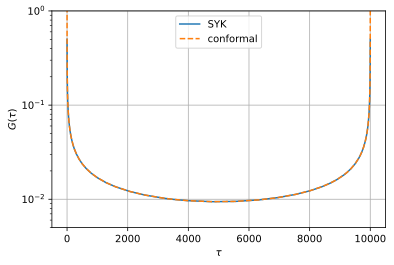

In [23]:
plt.plot(tau_l, -np.squeeze(g_l_root), label='SYK')
plt.plot(tau_l, -g_l_conformal, '--', label='conformal')
plt.semilogy([], [])
plt.ylim([5e-3, 1.])
plt.ylabel(r'$G(\tau)$')
plt.xlabel(r'$\tau$')
plt.legend(loc='best')
plt.grid(True)